# Demonstration of LFPykit


### LFPy 
- LFPy is for calculating brain signals (EAP, LFP, ECoG, EEG, MEG) from biophysically detailed neural simulations
- Built upon NEURON
- For both single cells and networks
- Is also a python wrapper around NEURON, to control simulations, insert synapses, etc.


### The problem
- There are other softwares for biohysically detailed neural simulations that might want to calculate some of the same brain signals
- If you have developed a network model outside of LFPy, it can be complicated to combine with methods from LFPy

### Our solution
- Neural simulations and calculations of brain signals are done separatly
    - Starting point for calculation of most brain signals are transmembrane currents and their locations
- Extract "forward models" from LFPy, and into new software independent of LFPy and NEURON 
    - LFPykit
- Transmembrane currents and cellular locations are given to a generic GeometryCell class
- Standadrized calculation of different brain signals

In [1]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

### Running the neural simulation
Here we use LFPy for the neural simulation, but other simulators that have representations of locations and transmembrane currents are equally valid

In [2]:
import neuron
import LFPy

# Load the L5PC model from Hay et al. (2011)
neuron.load_mechanisms('L5bPCmodelsEH/mod/')
cell_parameters = {
    'morphology': 'L5bPCmodelsEH/morphologies/cell1.asc',
    'templatefile': ['L5bPCmodelsEH/models/L5PCbiophys3.hoc',
                       'L5bPCmodelsEH/models/L5PCtemplate.hoc'],
    'templatename': 'L5PCtemplate',
    'templateargs': 'L5bPCmodelsEH/morphologies/cell1.asc',
    'passive': False,
    'nsegs_method': None,
    'dt': 2**-5,
    'tstart': -159,
    'tstop': 100,
    'v_init': -60,
    'celsius': 34,
    'pt3d': True,
}
cell = LFPy.TemplateCell(**cell_parameters)
cell.set_rotation(x=np.pi/2)

# Insert synaptic input
syn = LFPy.Synapse(cell, idx=0, syntype='ExpSyn', 
                   weight=0.03, tau=5, record_current=True)
syn.set_spike_times_w_netstim()

# Run cell simulation
cell.simulate(rec_imem=True)

# Extracting currents and their locations
I_memb = cell.imem
x = cell.x
y = cell.y
z = cell.z
d = cell.d


### Example 1: Calculating extracellular potentials
This part is independent of NEURON and LFPy

In [3]:
from lfpykit import CellGeometry, PointSourcePotential

ext_elec_params = {           
    'sigma': 0.3,  # extracellular conductivity (S/m)
    'x': np.array([35]),  # coordinates of electrode contacts (um)
    'y': np.array([0]),
    'z': np.array([0]),
}

cell_geometry = CellGeometry(x=x, y=y, z=z, d=d)

forward_model = PointSourcePotential(cell_geometry, **ext_elec_params)
M = forward_model.get_transformation_matrix()  # get linear response matrix

V_e = M @ I_memb  # compute extracellular potentials

 We first plot the cell response to the synaptic input

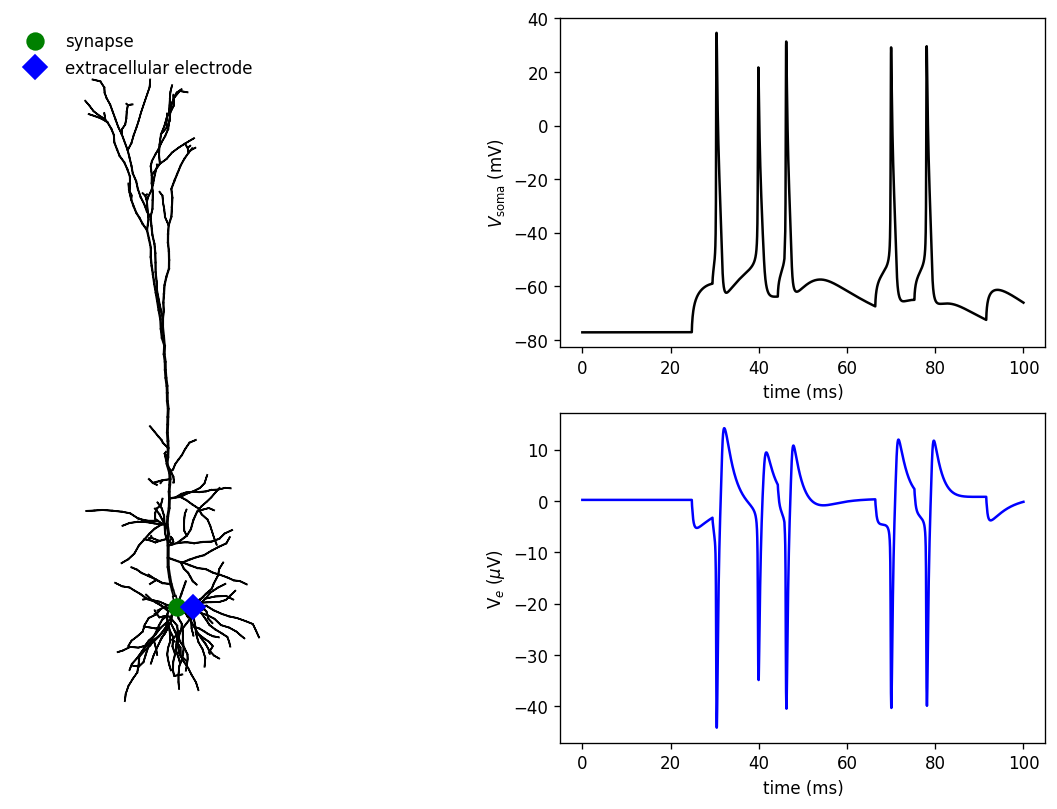

In [4]:
# Plotting the results
fig = plt.figure(figsize=(12, 8), dpi=120)
gs = GridSpec(2, 2, wspace=0.3)

# cell setup and sensor locations
ax0 = fig.add_subplot(gs[:, 0], aspect=1, frameon=False, 
                      xticks=[], yticks=[], ylim=[-300, 1300])
ax1 = fig.add_subplot(gs[0, 1], ylabel=r'$V_\mathrm{soma}$ (mV)', 
                      xlabel="time (ms)")
ax3 = fig.add_subplot(gs[1, 1], ylabel=r'V$_e$ ($\mu$V)', 
                      xlabel="time (ms)")

for xz in cell.get_idx_polygons(projection=('x', 'z')):
    ax0.add_patch(plt.Polygon(np.stack(xz).T, ec='k', fc='none', label='__nolabel__'))
ls, = ax0.plot(cell.x.mean(axis=1)[syn.idx], cell.x.mean(axis=1)[syn.idx], 'go', ms=10)
le, = ax0.plot(ext_elec_params['x'], ext_elec_params['z'], 'D', c='b', ms=10)

ax1.plot(cell.tvec, cell.somav, c='k')
ax3.plot(cell.tvec, 1000 * V_e[0], c='b')
    
ax0.legend([ls, le], ["synapse", "extracellular electrode"], 
           loc="upper right", frameon=False)


### Example 2: Calculating EEG signals with a complex head model
We now use the New York Head model to calculate EEG signals from the same neural simulation.
Note that this is just an example of the framework, and we do not expect single spikes to be measurable at EEG electrodes.

In [5]:
from lfpykit import CurrentDipoleMoment
from lfpykit.eegmegcalc import NYHeadModel

# calculate current dipole moment
cdm = CurrentDipoleMoment(cell=cell_geometry)
p = cdm.get_transformation_matrix() @ I_memb

nyhead = NYHeadModel()

nyhead.set_dipole_pos('parietal_lobe') # predefined example location

M = nyhead.get_transformation_matrix()
# We rotate current dipole moment to be oriented along the normal vector of cortex
p = nyhead.rotate_dipole_to_surface_normal(p)
eeg = M @ p *1e9 # [mV -> pV]

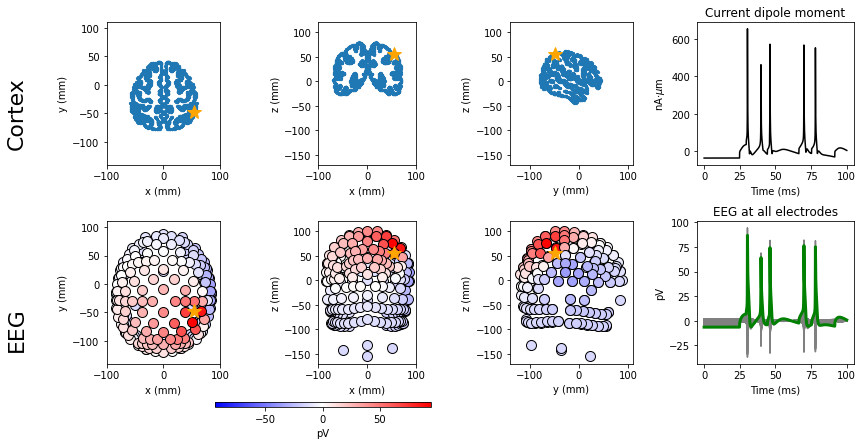

In [6]:
# Plotting the results

x_lim = [-100, 100]
y_lim = [-140, 110]
z_lim = [-170, 120]

t = cell.tvec

plt.close("all")
fig = plt.figure(figsize=[12, 6])
fig.subplots_adjust(top=0.96, bottom=0.17, hspace=0.4, 
                    wspace=0.3, left=0.1, right=0.99)
ax1 = fig.add_subplot(241, aspect=1, xlabel="x (mm)", 
                      ylabel='y (mm)', xlim=x_lim, ylim=y_lim)
ax2 = fig.add_subplot(242, aspect=1, xlabel="x (mm)", 
                      ylabel='z (mm)', xlim=x_lim, ylim=z_lim)
ax3 = fig.add_subplot(243, aspect=1, xlabel="y (mm)", 
                      ylabel='z (mm)', xlim=y_lim, ylim=z_lim)
ax_eeg = fig.add_subplot(248, xlabel="Time (ms)", 
                         ylabel='pV', title='EEG at all electrodes')
ax_cdm = fig.add_subplot(244, xlabel="Time (ms)", 
                         ylabel='nA$\cdot \mu$m', title='Current dipole moment')
ax7 = fig.add_subplot(245, aspect=1, xlabel="x (mm)", ylabel='y (mm)',
                      xlim=x_lim, ylim=y_lim)
ax8 = fig.add_subplot(246, aspect=1, xlabel="x (mm)", ylabel='z (mm)',
                      xlim=x_lim, ylim=z_lim)
ax9 = fig.add_subplot(247, aspect=1, xlabel="y (mm)", ylabel='z (mm)',
                      xlim=y_lim, ylim=z_lim)
cax = fig.add_axes([0.25, 0.07, 0.25, 0.01])
# Finding closest EEG electrode
dist, closest_elec_idx = nyhead.find_closest_electrode()
max_elec_idx = np.argmax(np.std(eeg, axis=1))
time_idx = np.argmax(np.abs(eeg[max_elec_idx]))

fig.text(0.01, 0.75, "Cortex", va='center', rotation=90, fontsize=22)
fig.text(0.01, 0.25, "EEG", va='center', rotation=90, fontsize=22)

ax_cdm.plot(t, p[2, :], 'k')
[ax_eeg.plot(t, eeg[idx, :], c='gray') for idx in range(eeg.shape[0])]
ax_eeg.plot(t, eeg[closest_elec_idx, :], c='green', lw=3)
# print(nyhead.eeg[50, :])

vmax = np.max(np.abs(eeg[:, time_idx]))
cmap = lambda v: plt.cm.bwr((v + vmax) / (2*vmax))

# Making cortical crossections
threshold = 2
xz_plane_idxs = np.where(np.abs(nyhead.cortex[1, :] - 
                                nyhead.dipole_pos[1]) < threshold)[0]
xy_plane_idxs = np.where(np.abs(nyhead.cortex[2, :] - 
                                nyhead.dipole_pos[2]) < threshold)[0]
yz_plane_idxs = np.where(np.abs(nyhead.cortex[0, :] - 
                                nyhead.dipole_pos[0]) < threshold)[0]
ax1.scatter(nyhead.cortex[0, xy_plane_idxs], nyhead.cortex[1, xy_plane_idxs], s=5)
ax2.scatter(nyhead.cortex[0, xz_plane_idxs], nyhead.cortex[2, xz_plane_idxs], s=5)
ax3.scatter(nyhead.cortex[1, yz_plane_idxs], nyhead.cortex[2, yz_plane_idxs], s=5)

# Plotting EEG signals
for idx in range(eeg.shape[0]):
    c = cmap(eeg[idx, time_idx])
    ax7.plot(nyhead.elecs[0, idx], nyhead.elecs[1, idx], 'o', 
             ms=10, c=c, zorder=nyhead.elecs[2, idx], mec='k')
    ax8.plot(nyhead.elecs[0, idx], nyhead.elecs[2, idx], 'o', 
             ms=10, c=c, zorder=-nyhead.elecs[1, idx], mec='k')
    ax9.plot(nyhead.elecs[1, idx], nyhead.elecs[2, idx], 'o', 
             ms=10, c=c, zorder=nyhead.elecs[0, idx], mec='k')

img = ax3.imshow([[], []], origin="lower", vmin=-vmax,
                 vmax=vmax, cmap=plt.cm.bwr)
plt.colorbar(img, cax=cax, shrink=0.5, orientation="horizontal", label="pV")

# Plotting dipole location
ax1.plot(nyhead.dipole_pos[0], nyhead.dipole_pos[1], '*', ms=15, color='orange')
ax2.plot(nyhead.dipole_pos[0], nyhead.dipole_pos[2], '*', ms=15, color='orange')
ax3.plot(nyhead.dipole_pos[1], nyhead.dipole_pos[2], '*', ms=15, color='orange')

ax7.plot(nyhead.dipole_pos[0], nyhead.dipole_pos[1], '*', ms=15, color='orange', zorder=500)
ax8.plot(nyhead.dipole_pos[0], nyhead.dipole_pos[2], '*', ms=15, color='orange', zorder=500)
ax9.plot(nyhead.dipole_pos[1], nyhead.dipole_pos[2], '*', ms=15, color='orange', zorder=500)
